In [1]:
import pandas as pd
import numpy as np

In [2]:
"""
This function is used to load the dataset
"""
def load_dataset():
    train_df = pd.read_csv("../Data/UNSW_NB15_testing-set.csv")
    test_df = pd.read_csv("../Data/UNSW_NB15_training-set.csv")
    return train_df, test_df

In [3]:
"""
This function is used to preprocess the attack_cat column
"""
def data_preprocessing_attack_cat(data):
    data["attack_cat"] = data["attack_cat"].fillna('Normal')
    data["attack_cat"] = data["attack_cat"].replace(' Fuzzers','Fuzzers')
    data["attack_cat"] = data["attack_cat"].replace(' Fuzzers ','Fuzzers')
    data["attack_cat"] = data["attack_cat"].replace(' Reconnaissance','Reconnaissance')
    data["attack_cat"] = data["attack_cat"].replace(' Reconnaissance ','Reconnaissance')
    data["attack_cat"] = data["attack_cat"].replace(' Shellcode','Shellcode')
    data["attack_cat"] = data["attack_cat"].replace(' Shellcode ','Shellcode')
    data["attack_cat"] = data["attack_cat"].replace('Backdoors','Backdoor')
    return data

In [4]:
"""
This function is used to visualize the attack_cat column

"""
def visualize_attack_cats(data):
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20,10))
    sns.countplot(x="attack_cat", data=data)
    plt.show()

In [5]:
"""
This function is used to preprocess the numerical columns

"""
def preprocess_numerical_cols(df):
    numerical_cols = df.select_dtypes(exclude=["object"]).columns
    df[numerical_cols] = df[numerical_cols].fillna(0)
    return df

In [6]:
"""
This function is used to preprocess the categorical columns


"""
def preprocess_categorical_cols(df):
    categorical_cols = df.select_dtypes(include=["object"]).columns
    categorical_cols = list(categorical_cols)
    categorical_cols.remove("attack_cat")
    df[categorical_cols] = df[categorical_cols].replace('-', "None")
    df[categorical_cols] = df[categorical_cols].fillna("None")
    return df

In [7]:
"""
This function is used to preprocess the data


"""
def preprocess_data(df):
    df = preprocess_numerical_cols(df)
    df = preprocess_categorical_cols(df)
    return df

In [8]:
"""
This function is used to one hot encode the column
"""
from sklearn.preprocessing import OneHotEncoder
def one_hot_encode_fit_col(data, col):
    values = data[col].unique()
    for index, v_col in enumerate(values):
        values[index] = col+"_"+v_col
        data[col+"_"+v_col] = np.zeros(len(data))
    enc = OneHotEncoder(handle_unknown='ignore')
    data[values] = enc.fit_transform(data[col].values.reshape(-1,1)).toarray()
    data = data.drop([col],axis=1)
    return data, enc, values

In [9]:
"""
This function is used to one hot encode the column
"""
def one_hot_encode_transform_col(data, col, enc, col_values):
    for v_col in col_values:
        data[v_col] = np.zeros(len(data))
    data[col_values] = enc.transform(data[col].values.reshape(-1,1)).toarray()
    data = data.drop([col],axis=1)
    return data

In [10]:
"""
This function is used to label encode the column
"""
def label_encoder_fit_col(data, col):
    values = ["out"]
    values.extend(data[col].unique())
    dict_values = {k: v for v, k in enumerate(values)}
    #print(dict_values)
    data[col] = data[col].apply(lambda x: dict_values[x])
    data[col] = data[col].astype("int32")
    return data, dict_values

In [11]:
"""
This function is used to label encode the column
"""
def label_encoder_transform_col(data, col, dict_values):
    data[col] = data[col].apply(lambda x: dict_values[x] if x in dict_values else 0)
    data[col] = data[col].astype("int32")
    return data

In [12]:
"""
This function is used to get the class weights

"""
from sklearn.utils import class_weight
def get_class_weights(y):
    class_weights = class_weight.compute_class_weight('balanced',
                                                     classes=np.unique(y),
                                                     y=y)
    class_weights = {k: v for k,v in enumerate(class_weights)}
    return class_weights

In [13]:
"""
This function is used to label encode the column

"""
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
def label_encode(y,num_classes):
    cls_label_encoder = LabelEncoder()
    y = cls_label_encoder.fit_transform(y)
    y = to_categorical(y, num_classes=num_classes)
    return y, cls_label_encoder

In [52]:
"""
This function is used to print the scores
"""
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, classification_report, precision_score, recall_score, f1_score
def print_score(y_pred, y_real,cls_label_encoder):
    print("Accuracy: ", accuracy_score(y_real, y_pred))
    print ("Precision Score: ", precision_score(y_real, y_pred, average='weighted'))
    print ("Recall Score: ", recall_score(y_real, y_pred, average='weighted'))
    print ("F1 Score: ", f1_score(y_real, y_pred, average='weighted'))
    print("Confusion Matrix")
    print(confusion_matrix(y_real, y_pred))


In [15]:
import keras.backend as K
"""
This function is used to calculate the f1 score
"""
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [16]:
"""
This function is used to min max scale the column
"""
from sklearn.preprocessing import MinMaxScaler
def min_max_scaler_fit_col(data):
    scaler = MinMaxScaler(feature_range=(0,1))
    data = scaler.fit_transform(data)
    return data

In [17]:
train_df,test_df = load_dataset()

In [18]:
train_df = train_df.drop(["id"], axis=1)
test_df = test_df.drop(["id"], axis=1)

In [19]:
train_df = data_preprocessing_attack_cat(train_df)
test_df = data_preprocessing_attack_cat(test_df)

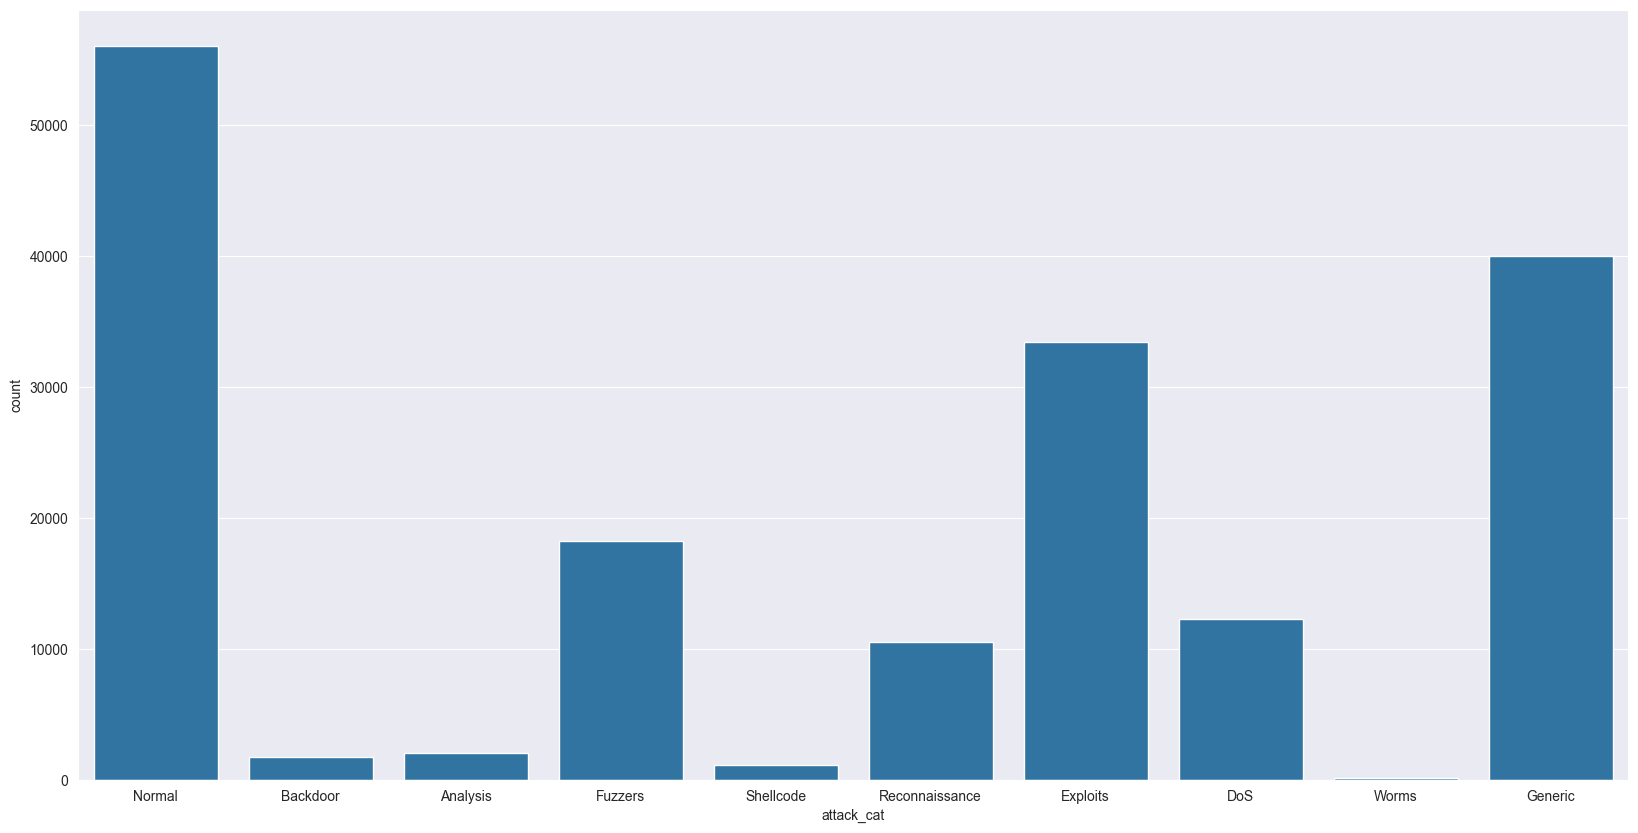

In [20]:
visualize_attack_cats(train_df)

In [21]:
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

In [22]:
train_df, dict_values = label_encoder_fit_col(train_df, "proto")
test_df = label_encoder_transform_col(test_df, "proto", dict_values)

In [23]:
train_df, dict_values = label_encoder_fit_col(train_df, "service")
test_df = label_encoder_transform_col(test_df, "service", dict_values)

In [24]:
train_df, dict_values = label_encoder_fit_col(train_df, "state")
test_df = label_encoder_transform_col(test_df, "state", dict_values)

In [25]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [26]:
X_train = train_df.drop(["label", "attack_cat"], axis=1)
y_train = train_df["attack_cat"]
X_test = test_df.drop(["label", "attack_cat"], axis=1)
y_test = test_df["attack_cat"]

In [27]:
X_train = min_max_scaler_fit_col(X_train)
X_test = min_max_scaler_fit_col(X_test)

In [28]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [29]:
class_weights = get_class_weights(y_train)

In [30]:
y_train, cls_label_encoder = label_encode(y_train, len(np.unique(y_train)))
y_test, _ = label_encode(y_test, len(np.unique(y_test)))

In [31]:
cls_label_encoder.classes_

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'], dtype=object)

In [32]:
print(y_train.shape)
print(y_test.shape)

(175341, 10)
(82332, 10)


In [33]:
print(X_train.shape)
print(X_test.shape)

(175341, 42, 1)
(82332, 42, 1)


In [34]:
"""
This function is used to build the Densenet model
"""
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool1D, GlobalAveragePooling1D, MaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate, GRU, Reshape
import tensorflow.keras.backend as K
#Densenet
def bn_rl_conv(x,filters,kernel=1,strides=1):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, kernel, strides=strides,padding = 'same')(x)
    return x
def dense_block(x, repetition, filters):        
    for _ in range(repetition):
        y = bn_rl_conv(x, 4*filters)
        y = bn_rl_conv(y, filters, 3)
        x = concatenate([y,x])
    return x
def transition_layer(x):
    x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
    x = AvgPool1D(2, strides = 2, padding = 'same')(x)
    return x
def build_densenet(input_shape, n_classes, filters = 32):
    input = Input (input_shape)
    x = Conv1D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool1D(3, strides = 2, padding = 'same')(x)   
    for repetition in [5,8,10,8]:
        d = dense_block(x, repetition, filters)
        x = transition_layer(d)    
    x = GlobalAveragePooling1D()(d)
    output = Dense(n_classes, activation = 'softmax')(x)   
    model = Model(input, output)
    return model

In [35]:
input_shape = X_train.shape[1:]

In [36]:
from sklearn.model_selection import ParameterSampler
import tensorflow as tf
def tune_hyperparams():
    # use random serch to tune hyperparameters
    params_grid = {
        'batch_size': [32, 64, 128],
        'epochs': [10, 20, 30],
        'learning_rate': [0.0001, 0.001, 0.01],
        'dropout_rate': [0.2, 0.25, 0.3],
        'activation': ['relu', 'leaky_relu', 'tan_h'],
        'optimizer': ['adam', 'sgd', 'rmsprop'],
        'filters': [8, 16, 32]
    }
    params_list = list(ParameterSampler(params_grid, n_iter=10, random_state=42))
    best_params = None
    for params in params_list:
        print("Trying Out : ",params)
        model = build_densenet(input_shape, 10, filters = params["filters"])
        if params["optimizer"] == "adam":
            optimizer = tf.keras.optimizers.Adam(learning_rate=params["learning_rate"])
        elif params["optimizer"] == "sgd":
            optimizer = tf.keras.optimizers.SGD(learning_rate=params["learning_rate"])
        else:
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=params["learning_rate"])
        model.compile(optimizer=optimizer, loss='binary_crossentropy', 
                 metrics=['accuracy', Precision(), Recall(), f1_score])
        model.fit(X_train, y_train, epochs=params["epochs"], batch_size=params["batch_size"],
                    validation_split=0.2, class_weight=class_weights)
        _, accuracy, precision, recall, f1 = model.evaluate(X_test, y_test, verbose=0)
        if best_params is None:
            best_params = params
            best_params["accuracy"] = accuracy
            best_params["precision"] = precision
            best_params["recall"] = recall
            best_params["f1"] = f1
        else:
            if f1 > best_params["f1"]:
                best_params = params
                best_params["accuracy"] = accuracy
                best_params["precision"] = precision
                best_params["recall"] = recall
                best_params["f1"] = f1
    print("Best Params : ", best_params)
        

In [37]:
# tune_hyperparams()

In [38]:
dnet_clf = build_densenet(input_shape, 10 , filters = 16)

In [39]:
from tensorflow.keras.metrics import Recall, Precision
import tensorflow.keras as keras
dnet_clf.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', 
                 metrics=['accuracy', Precision(), Recall(), f1_score])

In [40]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_weights_file_path = "dnet_mul_clf.h5"
checkpoint = ModelCheckpoint(filepath=model_weights_file_path, monitor="val_accuracy",
                             verbose=1, save_best_only=True, mode="max", save_weights_only=True)
early_stopping = EarlyStopping(monitor="val_accuracy", mode="max", verbose=1, patience=20,restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, 
                              verbose=1, mode='max', min_delta=0.0001, cooldown=0)

call_backs = [checkpoint, early_stopping, lr_reduce]

In [41]:
dnet_clf.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 42, 1)]              0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 21, 64)               512       ['input_1[0][0]']             
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 11, 64)               0         ['conv1d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 11, 64)               256       ['max_pooling1d[0][0]']   

In [42]:
EPOCHS = 50
BATCH_SIZE = 64
history_clf = dnet_clf.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
             validation_split=0.2, class_weight=class_weights, callbacks=call_backs)

Epoch 1/50
2192/2192 [==============================] - ETA: 0s - loss: 0.2034 - accuracy: 0.6382 - precision: 0.7893 - recall: 0.5803 - f1_score: 0.6659
Epoch 1: val_accuracy improved from -inf to 0.67487, saving model to dnet_mul_clf.h5
2192/2192 [==============================] - 121s 44ms/step - loss: 0.2034 - accuracy: 0.6382 - precision: 0.7893 - recall: 0.5803 - f1_score: 0.6659 - val_loss: 0.1535 - val_accuracy: 0.6749 - val_precision: 0.7662 - val_recall: 0.6081 - val_f1_score: 0.6774 - lr: 0.0010
Epoch 2/50
2191/2192 [============================>.] - ETA: 0s - loss: 0.1784 - accuracy: 0.6661 - precision: 0.8053 - recall: 0.6231 - f1_score: 0.7017
Epoch 2: val_accuracy did not improve from 0.67487
2192/2192 [==============================] - 89s 41ms/step - loss: 0.1784 - accuracy: 0.6662 - precision: 0.8053 - recall: 0.6232 - f1_score: 0.7018 - val_loss: 0.1607 - val_accuracy: 0.6458 - val_precision: 0.7840 - val_recall: 0.6130 - val_f1_score: 0.6873 - lr: 0.0010
Epoch 3/50


In [43]:
"""
This function is used to evaluate the model

"""
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, classification_report
def evaluate_Test(model, X_test, y_test, cls_label_encoder):
    y_hat = model.predict(X_test)
    y_hat = np.argmax(y_hat, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print_score(y_hat, y_true, cls_label_encoder)

In [44]:
"""
This function is used to visualize the loss


"""
def visualize_loss(history):
    import matplotlib.pyplot as plt
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

In [45]:
"""
This function is used to visualize the accuracy
"""
def visualize_accuracy(history):
    import matplotlib.pyplot as plt
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

In [46]:
"""
This function is used to plot the confusion matrix
"""
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(model, X_test, y_test):
    y_hat = model.predict(X_test)
    y_hat = np.argmax(y_hat, axis=1)
    y_true = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true, y_hat)
    plt.figure(figsize=(20,10))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=cls_label_encoder.classes_, yticklabels=cls_label_encoder.classes_)
    plt.show()

In [53]:
evaluate_Test(dnet_clf, X_test, y_test, cls_label_encoder)

2573/2573 [==============================] - 28s 11ms/step
Accuracy:  0.6514026138075111
Precision Score:  0.8271353746996667
Recall Score:  0.6514026138075111
F1 Score:  0.7100665677308624
Confusion Matrix
[[  110   506    24    14     1     0    22     0     0     0]
 [   77   443    15    36     5     0     1     6     0     0]
 [  564  2250   555   572    49     0    12    46    24    17]
 [  631  2536   692  6516    99     5    22   417    21   193]
 [  198  1043   221  1770  2141     0   115   306   234    34]
 [   14    39   189   390  1118 16906     9   176    22     8]
 [ 2070    36   505  3759  7910     0 22043   170   473    34]
 [   60   265   489   590    53     0     1  1448   578    12]
 [    0     1    33    95    13     0     0    93   140     3]
 [    0     0     1     5     0     0     2     0     0    36]]


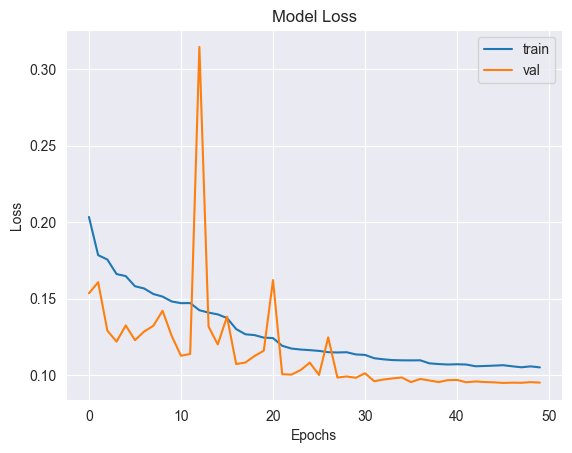

In [54]:
visualize_loss(history_clf)

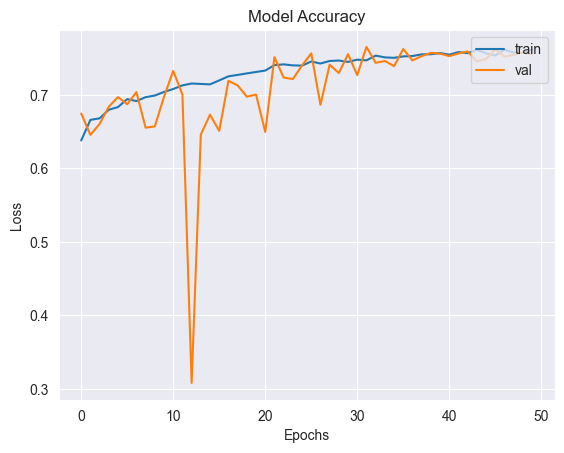

In [55]:
visualize_accuracy(history_clf)

2573/2573 [==============================] - 27s 11ms/step


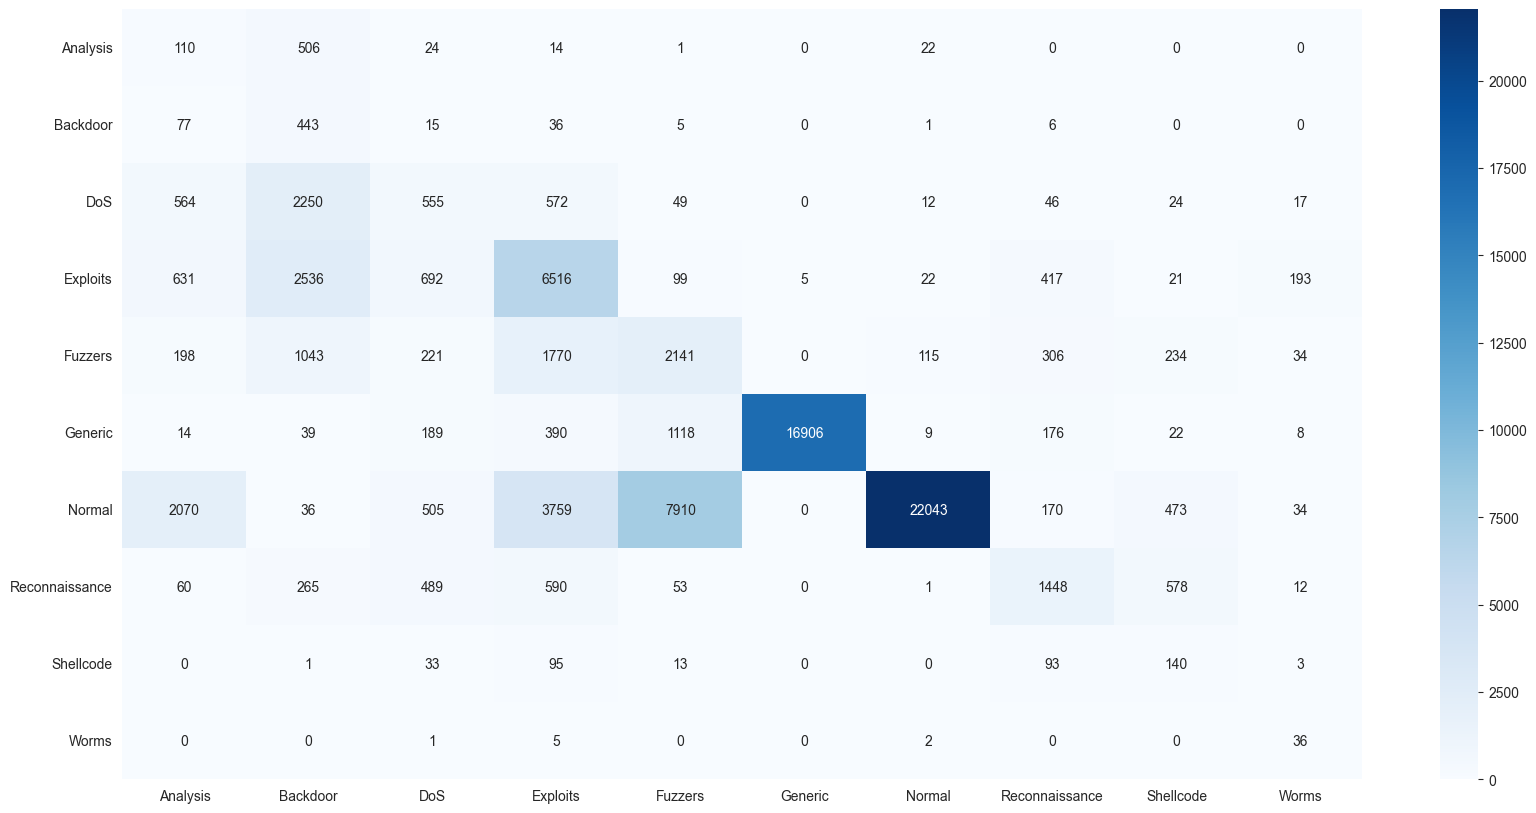

In [56]:
plot_confusion_matrix(dnet_clf, X_test, y_test)

In [ ]:
# Save the entire model as 'desnet_mulclf.h5' file
dnet_clf.save('dnet_mulclf.h5')